# Retail Demo

https://github.com/bigdatavik/GDS_Retail_Demo


In [1]:
from neo4j import GraphDatabase

# tag::imports[]
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# end::imports[]

In [2]:
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "letmein"))

print(driver.address)

localhost:7687


In [19]:
import_queries = """

CREATE CONSTRAINT ON (i:Item) ASSERT i.StockCode IS UNIQUE;
CREATE CONSTRAINT ON (c:Customer) ASSERT c.CustomerID IS UNIQUE;
CREATE CONSTRAINT ON (t:Transaction) ASSERT t.TransactionID IS UNIQUE;
CREATE CONSTRAINT ON (c:Category) ASSERT c.Category IS UNIQUE;
CREATE CONSTRAINT ON (c:Country) ASSERT c.Name IS UNIQUE;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/UniqueCategories.csv" AS row
WITH row.ITEMCATEGORY as ItemCategory
MERGE (c:Category{Category:ItemCategory})
RETURN COUNT (c);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/UniqueItems.csv" AS row
WITH toInteger(row.StockCode) as StockCode, row.Description as Description where StockCode is not null
MERGE (i:Item{StockCode: StockCode, Description:Description})
RETURN COUNT (i);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/UniqueCountries.csv" AS row
WITH row.Country as CountryName
MERGE (c:Country{Country:CountryName})
RETURN COUNT (c);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/UniqueHouseholds.csv" AS row
WITH toInteger(row.CustomerID) as CustomerID
MERGE (c:Customer{CustomerID:CustomerID})
RETURN COUNT (c);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/UniqueTransactions.csv" AS row
WITH toInteger(row.Transaction_ID) as TransactionID, row.InvoiceDate as InvoiceDate, toInteger(row.epochtime) as EpochTime
MERGE (t:Transaction{TransactionID:TransactionID, InvoiceDate:InvoiceDate, EpochTime:EpochTime})
RETURN COUNT (t);

//Add relationships
USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/item-category.csv" as row
WITH toInteger (row.StockCode) as StockCode, row.CATEGORY as Category
MATCH (i:Item{StockCode:StockCode})
MATCH (c:Category{Category:Category})
MERGE (i)-[:TYPE]->(c);

USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/household-transaction.csv" as row
WITH toInteger(row.CustomerID) as CustomerID, toInteger(row.Transaction_ID) as TransactionID
MATCH (c:Customer{CustomerID:CustomerID})
MATCH (t:Transaction{TransactionID:TransactionID})
MERGE (c)-[:MADE_TRANSACTION]->(t);

USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/household-country.csv" as row
WITH toInteger(row.CustomerID) as CustomerID, row.Country as Country
MATCH (c:Customer{CustomerID:CustomerID})
MATCH (c2:Country{Country:Country})
MERGE (c)-[:FROM]->(c2);

USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/customer-item.csv" as row
WITH toInteger(row.NumberPurchased) as NumberPurchase, toInteger(row.CustomerID) as CustomerID, tointeger (row.StockCode) as StockCode
MATCH (c:Customer{CustomerID:CustomerID})
MATCH (i:Item {StockCode:StockCode})
MERGE (c)-[:BOUGHT{Quantity:NumberPurchase}]->(i);

USING PERIODIC COMMIT 500
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/AliciaFrame/GDS_Retail_Demo/master/Data/transaction-item.csv" as row
WITH tointeger (row.StockCode) as StockCode, toFloat(row.Price) as Price, toInteger(row.Transaction_ID) as TransactionID, toInteger(row.Quantity) as Quantity
MATCH (i:Item{StockCode:StockCode})
MATCH (t:Transaction{TransactionID:TransactionID})
MERGE (t)-[:CONTAINS{Quantity:Quantity, Price:Price}]->(i);

//set item specific prices and quantities
MATCH (i:Item)-[c:CONTAINS]-(t:Transaction)
WITH  i, AVG(c.Price) as Price, count(c) as Num_Sold
SET i.avg_price=Price, i.num_sold = Num_Sold
RETURN count(i)

"""
with driver.session() as session:
    for statement in import_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

### DB Schema

In [3]:
query = """
CALL db.schema.visualization;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodes,relationships
0,"[(name, indexes, constraints), (name, indexes,...","[(), (), (), (), (), (), (), (), (), (), (), ()]"


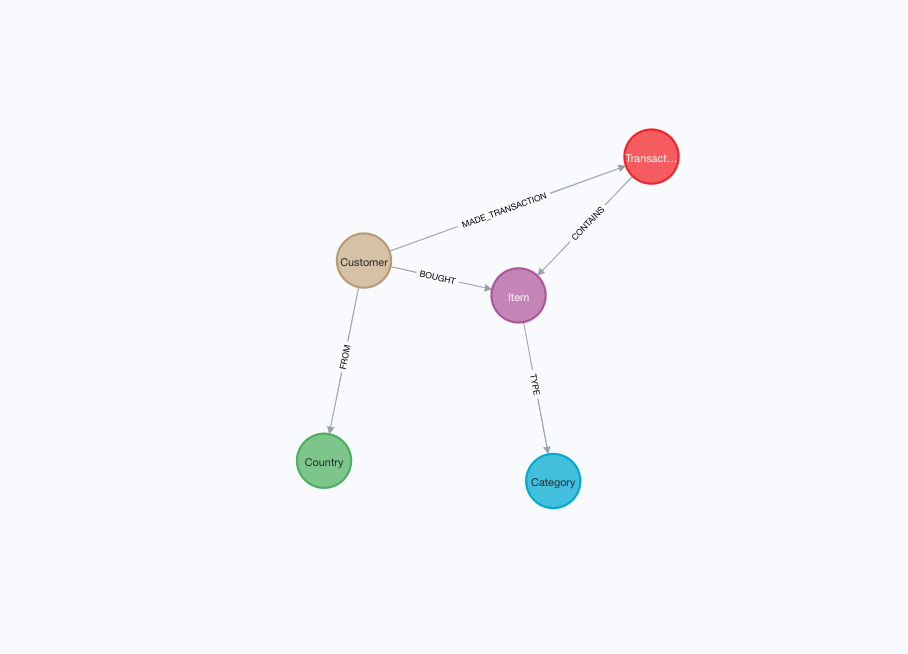

### Clean up Demo

In [29]:
run_queries = """

// Drop all models
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;

// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;

// REMOVE properties
MATCH (i:Item) REMOVE i.embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding;
MATCH (i:Item) REMOVE i.node2vec_embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding_everything;

// Delete extra OWLs
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
DETACH DELETE i;

// REMOVE extra similarity rels
UNWIND ['SIMILAR_EMBEDDING', 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE','SIMILAR_GRAPHSAGE_EMBEDDING','SIMILAR_GRAPHSAGE_EMBEDDING_KNN', 'SIMILAR_NODE2VEC_EMBEDDING',
      'SIMILAR_EVERYTHING_EMBEDDING', 'Similar', 'SIMILAR'] as rel
MATCH ()-[r]->() WHERE type(r) = rel
DELETE r;   
"""


with driver.session() as session:
    for statement in run_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

# 1. Customer Segmentation

### 1. customer similarity by category

In [20]:
query = """
//1. customer similarity by category
CALL gds.graph.create.cypher(
    'Customer_Similarity_Graph_Category',
    'MATCH (n) WHERE n:Customer OR n:Category RETURN id(n) AS id',
    'MATCH (c:Customer)-->(:Transaction)-->(:Item)-->(c2:Category) RETURN id(c) as source, id(c2) as target'
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (n) WHERE n:Customer OR n:Category RETUR...,MATCH (c:Customer)-->(:Transaction)-->(:Item)-...,Customer_Similarity_Graph_Category,4384,31810844,8896


### 2. node similarity: customers by category

In [21]:
query = """
//2. node similarity: customers by category
CALL gds.nodeSimilarity.mutate('Customer_Similarity_Graph_Category', 
                               {mutateRelationshipType:'Similar', 
                                mutateProperty:'score',topK:10, similarityCutoff:0.25});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,createMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,0,701,5,-1,4371,43707,"{'p1': 0.7777767181396484, 'max': 1.0000057220...","{'topK': 10, 'bottomK': 10, 'bottomN': 0, 'rel..."


In [ ]:
### 3. Louvain stream

In [22]:
query = """
//3. Louvain stream
CALL gds.louvain.stream('Customer_Similarity_Graph_Category',
                        {relationshipTypes:['Similar'], 
                        relationshipWeightProperty:'score'}) 
                        YIELD nodeId, communityId 
                        RETURN communityId, count(nodeId) as size 
                        ORDER by size DESC;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,communityId,size
0,1,4300
1,4324,71
2,4340,1
3,4372,1
4,4373,1
5,4374,1
6,4375,1
7,4376,1
8,4377,1
9,4378,1


### 4. drop graph

In [23]:
query = """
//4. drop graph
CALL gds.graph.drop('Customer_Similarity_Graph_Category');
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,Customer_Similarity_Graph_Category,neo4j,33 MiB,35645400,"{'relationships': {'total': 34163616, 'everyth...",None,None,MATCH (n) WHERE n:Customer OR n:Category RETUR...,MATCH (c:Customer)-->(:Transaction)-->(:Item)-...,4384,31854551,1.658,2021-03-26T13:47:34.409671000-04:00,2021-03-26T13:48:17.435209000-04:00,{'relationships': {'Similar': {'score': 'Float...


### 5. native load - Customer Similarity by Item 

In [ ]:
query = """
//5. native load - Customer Similarity by Item 
CALL gds.graph.create(
    'Customer_Similarity_Graph_Items',
    ['Customer','Item'],
    'BOUGHT'
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


### 6. node similarity

In [ ]:
query = """
//6. node similarity
CALL gds.nodeSimilarity.mutate('Customer_Similarity_Graph_Items', 
                               {mutateRelationshipType:'Similar', 
                                mutateProperty:'score',topK:10, similarityCutoff:0.1});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

### CALL gds.graph.writeRelationship('Customer_Similarity_Graph_Items', 'SIMILAR_TO')

### 7. Louvain stream

In [31]:
query = """
//7. Louvain stream
CALL gds.louvain.stream('Customer_Similarity_Graph_Items',
{relationshipTypes:['Similar'], relationshipWeightProperty:'score'}) 
YIELD nodeId, communityId 
RETURN communityId, count(nodeId) as size 
ORDER by size DESC;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,communityId,size
0,2929,389
1,7002,340
2,5421,303
3,5214,291
4,3670,291
...,...,...
4723,6314,1
4724,6316,1
4725,6317,1
4726,6322,1


### 8. Louvain mutate and Write mutated result back

In [34]:
query = """  
//8. Louvain mutate
CALL gds.louvain.mutate('Customer_Similarity_Graph_Items',
{relationshipTypes:['Similar'], relationshipWeightProperty:'score', mutateProperty:'louvainCommunity'});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.louvain.mutate`: Caused by: java.lang.IllegalArgumentException: Node property `louvainCommunity` already exists in the in-memory graph.}

In [35]:
query = """ 
//Write mutated result back
CALL gds.graph.writeNodeProperties('Customer_Similarity_Graph_Items',['louvainCommunity']);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,writeMillis,graphName,nodeProperties,propertiesWritten
0,112,Customer_Similarity_Graph_Items,[louvainCommunity],7236


### 9. export graph

In [ ]:
query = """ 
//9. export graph
CALL gds.beta.graph.export('Customer_Similarity_Graph_Items',{dbName:'CustomerSegmentation'});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

# 2a. Item Similarity

In [37]:
query = """ 
// 1. Item similarity - 2929
CALL gds.graph.drop('Customer_Similarity_Graph_Items');

// item similarity louvain 2929
CALL gds.graph.create.cypher(
    'Item_Similarity_2929',
    'MATCH (n) WHERE n:Transaction or n:Item return id(n) as id',
    'MATCH (t:Transaction)<--(c:Customer) WHERE c.louvainCommunity = 2929 WITH t MATCH (i:Item)<--(t) RETURN distinct id(i) as source, id(t) as target'
);

//mutate for item sim 2929
CALL gds.nodeSimilarity.mutate('Item_Similarity_2929',{mutateRelationshipType:'SIMILAR_2929', mutateProperty:'score'});

//write new relationship back
CALL gds.graph.writeRelationship('Item_Similarity_2929','SIMILAR_2929','score');

//drop graph
CALL gds.graph.drop('Item_Similarity_2929');
"""

with driver.session() as session:
    for statement in query.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

In [38]:
query = """ 
// 2. Item similarity - 7002

// item similarity louvain 7002
CALL gds.graph.create.cypher(
    'Item_Similarity_7002',
    'MATCH (n) WHERE n:Transaction or n:Item return id(n) as id',
    'MATCH (t:Transaction)<--(c:Customer) WHERE c.louvainCommunity = 7002 WITH t MATCH (i:Item)<--(t) RETURN distinct id(i) as source, id(t) as target'
);

//mutate for item sim 7002
CALL gds.nodeSimilarity.mutate('Item_Similarity_7002',{mutateRelationshipType:'SIMILAR_7002', mutateProperty:'score'});

//write new relationship back
CALL gds.graph.writeRelationship('Item_Similarity_7002','SIMILAR_7002','score');

//drop graph
CALL gds.graph.drop('Item_Similarity_7002');
"""

with driver.session() as session:
    for statement in query.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

# 2b. Item Centrality

In [40]:
query = """ 
//1. item centrality - 2929
CALL gds.graph.create.cypher('item_copurchase_2929','MATCH (i:Item)<--(c:Customer) where c.louvainCommunity = 2929 RETURN DISTINCT id(i) as id','MATCH (i1:Item)<--(c:Customer)-->(i2:Item) WHERE c.louvainCommunity = 2929 RETURN distinct id(i1) as source, id(i2) as target, count(c) as weight');

//item closeness
CALL gds.alpha.closeness.write('item_copurchase_2929',{writeProperty:'Closeness_Centrality_Community_2929'});

//item pagerank
CALL gds.pageRank.write('item_copurchase_2929',{relationshipWeightProperty:'weight',writeProperty:'PageRank_Community_2929'});

//drop graph
CALL gds.graph.drop('item_copurchase_2929');
"""

with driver.session() as session:
    for statement in query.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

In [41]:
query = """ 
//2. item centrality - 7002
CALL gds.graph.create.cypher('item_copurchase_7002','MATCH (i:Item)<--(c:Customer) where c.louvainCommunity = 7002 RETURN DISTINCT id(i) as id','MATCH (i1:Item)<--(c:Customer)-->(i2:Item) WHERE c.louvainCommunity = 7002 RETURN distinct id(i1) as source, id(i2) as target, count(c) as weight');

//item closeness
CALL gds.alpha.closeness.write('item_copurchase_7002',{writeProperty:'Closeness_Centrality_Community_7002'});

//item pagerank
CALL gds.pageRank.write('item_copurchase_7002',{relationshipWeightProperty:'weight',writeProperty:'PageRank_Community_7002'});

//drop graph
CALL gds.graph.drop('item_copurchase_7002');
"""

with driver.session() as session:
    for statement in query.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass


# 3. ExploratoryQueries

In [43]:
query = """ 
//1. find items that are similar in 2929 and not 7002
MATCH p=(i1:Item)-[r:SIMILAR_2929]->(i2) 
WHERE NOT (i1:Item)-[r:SIMILAR_7002]->(i2) 
AND r.score > .1 AND r.score < .8
RETURN i1.Description, i2.Description, r.score as score order by score desc;
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,i1.Description,i2.Description,score
0,HERB MARKER MINT,HERB MARKER PARSLEY,0.794
1,HERB MARKER PARSLEY,HERB MARKER MINT,0.794
2,CLASSIC BICYCLE CLIPS,BICYCLE PUNCTURE REPAIR KIT,0.791
3,BICYCLE PUNCTURE REPAIR KIT,CLASSIC BICYCLE CLIPS,0.791
4,HERB MARKER BASIL,HERB MARKER ROSEMARY,0.787
...,...,...,...
18338,REGENCY TEA STRAINER,REGENCY TEA PLATE ROSES,0.100
18339,FELTCRAFT 6 FLOWER FRIENDS,12 PENCILS SMALL TUBE RED RETROSPOT,0.100
18340,EMBOSSED GLASS TEALIGHT HOLDER,AIRLINE LOUNGE METAL SIGN,0.100
18341,GUMBALL MONOCHROME COAT RACK,SET/2 RED RETROSPOT TEA TOWELS,0.100


In [44]:
query = """ 
//2. find items that are similar in 7002 and not 2929
MATCH p=(i1:Item)-[r:SIMILAR_7002]->(i2) 
WHERE NOT (i1:Item)-[r:SIMILAR_2929]->(i2) 
AND r.score > .1 AND r.score < .8
RETURN i1.Description, i2.Description, r.score as score order by score desc
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,i1.Description,i2.Description,score
0,SNACK TRAY I LOVE LONDON,BICYCLE PUNCTURE REPAIR KIT,0.786
1,BICYCLE PUNCTURE REPAIR KIT,SNACK TRAY I LOVE LONDON,0.786
2,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.737
3,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.737
4,CLASSIC BICYCLE CLIPS,SNACK TRAY PAISLEY PARK,0.733
...,...,...,...
23310,BUNDLE OF 3 ALPHABET EXERCISE BOOKS,SET OF 12 FAIRY CAKE BAKING CASES,0.101
23311,PACK OF 6 SKULL PAPER PLATES,SET3 BOOK BOX GREEN GINGHAM FLOWER,0.101
23312,REGENCY TEA SPOON,REGENCY TEA PLATE ROSES,0.101
23313,PACK OF 20 SPACEBOY NAPKINS,PACK OF 60 SPACEBOY CAKE CASES,0.101


In [45]:
query = """ 
// 3. different pageRanks
MATCH (i:Item) 
WHERE i.PageRank_Community_2929 > 1.5
AND i.PageRank_Community_7002 < .75
RETURN i.Description, i.PageRank_Community_2929, i.PageRank_Community_7002
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,i.Description,i.PageRank_Community_2929,i.PageRank_Community_7002
0,KEY FOB FRONT DOOR,1.634,0.720
1,CLASSIC METAL BIRDCAGE PLANT HOLDER,1.966,0.664
2,ENAMEL WATERING CAN CREAM,1.503,0.636
3,BAKING MOULD HEART WHITE CHOCOLATE,1.556,0.625
4,COTTON APRON PANTRY DESIGN,1.548,0.550
5,DOORKNOB CERAMIC IVORY,1.603,0.698
6,DOORSTOP RETROSPOT HEART,1.787,0.528
7,EMBOSSED GLASS TEALIGHT HOLDER,1.652,0.360
8,ENCHANTED BIRD COATHANGER 5 HOOK,1.763,0.610
9,FRENCH KITCHEN SIGN BLUE METAL,1.574,0.527


In [46]:
query = """
// 4. High centrality, low pagerank
MATCH (i:Item) 
WHERE i.PageRank_Community_2929 < .7
AND i.Closeness_Centrality_Community_2929 > .7
RETURN i.Description, i.PageRank_Community_2929, i.Closeness_Centrality_Community_2929
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,i.Description,i.PageRank_Community_2929,i.Closeness_Centrality_Community_2929
0,AFGHAN SLIPPER SOCK PAIR,0.367,0.734
1,ASSORTED TUTTI FRUTTI KEYRING BALL,0.422,0.741
2,ASSORTED TUTTI FRUTTI LARGE PURSE,0.533,0.793
3,ASSORTED TUTTI FRUTTI MIRROR,0.614,0.836
4,ASSORTED TUTTI FRUTTI SMALL PURSE,0.626,0.834
...,...,...,...
646,VINTAGE WOODEN BAR STOOL,0.307,0.709
647,WHITE GOOSE FEATHER TREE 60CM,0.670,0.845
648,WHITE SAGE INCENSE,0.433,0.751
649,WHITE TISSUE REAM,0.421,0.754


In [47]:
query = """
//5. high pagerank, low closeness
MATCH (i:Item) 
WHERE i.PageRank_Community_7002 > 1
AND i.Closeness_Centrality_Community_7002 < 0.75
RETURN i.Description, i.PageRank_Community_7002 as pageRank, i.Closeness_Centrality_Community_7002 as closeness order by pageRank DESC
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,i.Description,pageRank,closeness
0,JUMBO BAG DOLLY GIRL DESIGN,4.722,0.749
1,PAPER CHAIN KIT 50'S CHRISTMAS,4.498,0.747
2,JUMBO BAG PAISLEY PARK,4.459,0.748
3,HEART OF WICKER SMALL,4.381,0.747
4,REGENCY CAKESTAND 3 TIER,4.371,0.748
...,...,...,...
637,WRAP POPPIES DESIGN,1.006,0.581
638,ALARM CLOCK BAKELIKE ORANGE,1.006,0.579
639,FRENCH WC SIGN BLUE METAL,1.004,0.578
640,HANGING CHICK CREAM DECORATION,1.002,0.581


# GraphSAGE_Demo

### 1. schema

In [ ]:
query = """
// 1. schema
//schema
call db.schema.visualization()
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


### 2. load a multipartite graph

In [52]:
query = """
//2. load a multipartite graph

CALL gds.graph.create(
  'retail_graph',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'Price',
          defaultValue: 0.0
        },
        StockCode: {
         property: 'StockCode',
         defaultValue: 0
       }
     }
    },
    Transaction: {
      label: 'Transaction',
      properties: {
       EpochTime:{
       	property:'EpochTime',
        defaultValue:0
       },
       TransactionID:{
       	property:'TransactionID',
        defaultValue:0
       },
       quantity:{
       	property:'num_sold',
        defaultValue:0
       }
     }
    }

 
 }, {
    
    CONTAINS: {
      type: 'CONTAINS',
      orientation: 'UNDIRECTED'
    }
})
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Transaction': {'properties': {'quantity': {'...,"{'CONTAINS': {'orientation': 'UNDIRECTED', 'ag...",retail_graph,22713,944668,64


### 3. Train GraphSAGE

In [53]:
query = """
//3. Train GraphSAGE

CALL gds.beta.graphSage.train(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo',
    //which features should we use? all of them!
    featureProperties: ['price', 'quantity','StockCode','EpochTime','TransactionID'],
    //specify the projected feature dimension
    projectedFeatureDimension:7, //2 labels + 5 properties
    degreeAsProperty: true, //adding more properties
    epochs: 3, //how many times to traverse the graph during training
    searchDepth:5 //depth of the random walk
  }
)
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,retail_graph,{},"{'name': 'graphsage_multipartite_demo', 'type'...","{'maxIterations': 10, 'negativeSampleWeight': ...",39219


### 4. Check the model catalog

In [54]:
query = """
//4. Check the model catalog
call gds.beta.model.list()
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,modelInfo,trainConfig,graphSchema,loaded,stored,creationTime,shared
0,"{'modelName': 'graphsage_multipartite_demo', '...","{'maxIterations': 10, 'negativeSampleWeight': ...","{'relationships': {'CONTAINS': {}}, 'nodes': {...",True,False,2021-03-26T17:39:11.207110000-04:00,False


### 5. What are embeddings again?

In [60]:
query = """
//5. What are embeddings again?
CALL gds.beta.graphSage.stream(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo'
  });
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeId,embedding
0,12,"[0.9999999984051786, 5.672786812795984e-07, 1...."
1,13,"[0.999999999585914, 1.82440767832189e-07, 6.18..."
2,14,"[0.9999999992180477, 3.217058238486489e-07, 9...."
3,15,"[0.9999999992180477, 3.217058238486489e-07, 9...."
4,16,"[0.9999999984051786, 5.672786812795984e-07, 1...."
...,...,...
22708,27130,"[0.999999999585914, 1.82440767832189e-07, 6.18..."
22709,27131,"[0.999999999585914, 1.82440767832189e-07, 6.18..."
22710,27132,"[0.999999999585914, 1.82440767832189e-07, 6.18..."
22711,27133,"[0.999999999585914, 1.82440767832189e-07, 6.18..."


### 6. Add embeddings to the in-memory graph

In [57]:
query = """
//6. Add embeddings to the in-memory graph
CALL gds.beta.graphSage.mutate(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo',
    mutateProperty:'Embedding'
  });
  """
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodePropertiesWritten,mutateMillis,nodeCount,createMillis,computeMillis,configuration
0,22713,0,22713,0,6540,"{'modelName': 'graphsage_multipartite_demo', '..."


### 7. create a monopartite projection

In [58]:
query = """
// 7. create a monopartite projection

CALL gds.alpha.collapsePath.mutate(
  'retail_graph',
  {
    relationshipTypes: ['CONTAINS', 'CONTAINS'],
    allowSelfLoops: false,
    mutateRelationshipType: 'BOUGHT_TOGETHER'
  }
) YIELD relationshipsWritten
 """
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,relationshipsWritten
0,91653340


### 8. FastRP Embeddings

In [ ]:
query = """
//8. FastRP Embeddings
CALL gds.beta.fastRPExtended.write(
  'retail_graph',
  {
    nodeLabels:['Item'],
    relationshipTypes:['BOUGHT_TOGETHER'],
    featureProperties:['price','quantity'],
    embeddingDimension: 10,
    propertyDimension:4, //good starting point: 2x the number of properties, must be less than embeddingDimension
    writeProperty: 'fastrp-Embedding'
  }
)
YIELD nodePropertiesWritten
"""
with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

### 9. build knn graph

In [62]:
query = """
// 9. build knn graph
//9. build knns graph
//graphsage
CALL gds.beta.knn.write('retail_graph', {
    writeRelationshipType: 'SIMILAR_GRAPHSAGE_EMBEDDING',
    writeProperty: 'score',
    topK: 3,
    randomSeed: 42,
    nodeWeightProperty: 'Embedding'
})
YIELD nodesCompared, relationshipsWritten;

//fastRPExtended
CALL gds.beta.knn.write({
     nodeProjection:'Item',
     relationshipProjection:'CONTAINS',
     nodeProperties:'fastrp-Embedding',
     writeRelationshipType: 'SIMILAR_FASTRP_EMBEDDING',
     writeProperty: 'score',
     topK: 3,
     randomSeed: 42,
     nodeWeightProperty: 'fastrp-Embedding'    
});
"""

with driver.session() as session:
    for statement in query.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

### Load Item Affinity Graph

In [22]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
      copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2864,2430254,479


### **Node2Vec** on items Graph

In [23]:
query = """
CALL gds.alpha.node2vec.stream('items', {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     concurrency:4});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeId,embedding
0,12,"[-0.48127540946006775, 0.18506743013858795, 0...."
1,13,"[0.4862574338912964, 0.5233066082000732, 0.576..."
2,14,"[-0.05882648006081581, 0.3673568665981293, 0.2..."
3,15,"[-0.09630923718214035, 0.27312034368515015, 0...."
4,16,"[-0.2119910717010498, 0.3726838231086731, 0.33..."
...,...,...
2859,2871,"[-0.31048938632011414, 0.17524071037769318, 0...."
2860,2872,"[0.7993035912513733, -0.012966255657374859, -0..."
2861,2873,"[-0.12410412728786469, 0.3660004138946533, -0...."
2862,2874,"[-0.3239247798919678, 0.0857771709561348, 0.03..."


### **Node2Vec** write embeddings to graph

In [24]:
query = """
CALL gds.alpha.node2vec.write('items', 
    {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     writeProperty:'node2vec_embedding',
     concurrency:4
    }
)
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2864,2864,0,745185,370,"{'initialLearningRate': 0.025, 'writeConcurren..."


### **Calculate Similarity**

In [25]:
query = """
MATCH (i:Item)
 WITH {item:id(i), weights: i.node2vec_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_NODE2VEC_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,min,max,mean,stdDev
0,0.726,1.000,0.961,0.050


### **GraphSAGE** model training on items graph

In [26]:
query = """
CALL gds.beta.graphSage.train(
  'items',
  {
    embeddingDimension: 16,
    modelName: 'graphsage_demo',
    featureProperties: ['total_sold_scaled', 'price_scaled'],
    aggregator: 'pool', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,items,{},"{'name': 'graphsage_demo', 'type': 'graphSage'}","{'maxIterations': 10, 'negativeSampleWeight': ...",27386


### **Add new data**

In [27]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item) where i.Description contains('SPACE OWL') WITH i, descr
CREATE (i2:Item{Description:descr})
CREATE (i) - [:COPURCHASED] -> (i2)
CREATE (i) <- [:COPURCHASED] - (i2);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

""


### **Drop and Load affinity graph again**

In [28]:
query = """
CALL gds.graph.drop('items');
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,items,neo4j,3063 KiB,3137496,"{'relationships': {'total': 2908528, 'everythi...",{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",None,None,2864,2430254,0.296,2021-03-25T11:01:57.540516000-04:00,2021-03-25T11:01:59.243571000-04:00,"{'relationships': {'copurchased': {}}, 'nodes'..."


In [29]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
    copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2869,2430274,154


### **Apply saved model to predict embeddings**

In [30]:
query = """
CALL gds.beta.graphSage.write(
  'items',
  {
    writeProperty:'graphsage_embedding',
    modelName: 'graphsage_demo'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results


,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2869,2869,0,1814,95,"{'modelName': 'graphsage_demo', 'writeConcurre..."


### **Check embeddings for newly added data**

In [31]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
RETURN i.Description, i.graphsage_embedding;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results


,i.Description,i.graphsage_embedding
0,SEA OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
1,LAND OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
2,FIRE OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
3,FOREST OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
4,POTATO OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."


### **Calculate Similarity embedding**

In [32]:
query = """
 MATCH (i:Item)
 WITH {item:id(i), weights: i.graphsage_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_GRAPHSAGE_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,min,max,mean,stdDev
0,1.000,1.000,1.000,0.000


## **GraphSAGE** multipartite graph

In [5]:
query = """
// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName
0,retail_graph


In [6]:
query = """
CALL gds.graph.create(
  'retail_graph',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
          property: 'avg_price_scaled',
          defaultValue: 0.0
        },
        total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
     }
    },
    Transaction: {
      label: 'Transaction',
      properties: {
       EpochTime:{
       	property:'EpochTime',
        defaultValue:0
       }
     }
    }

 
 }, {
    
    CONTAINS: {
      type: 'CONTAINS',
      orientation: 'UNDIRECTED'
    }
});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Transaction': {'properties': {'EpochTime': {...,"{'CONTAINS': {'orientation': 'UNDIRECTED', 'ag...",retail_graph,22718,944668,78


### Train a GraphSAGE model

In [9]:
query = """
// Drop all models, commumity edition, allows one model only
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

""


In [10]:
query = """
CALL gds.beta.graphSage.train(
  'retail_graph',
  {
    embeddingDimension: 8,
    modelName: 'graphsage_multipartite_demo',
    //which features should we use? all of them!
    featureProperties: ['price_scaled', 'EpochTime','total_sold_scaled'],
    //specify the projected feature dimension
    projectedFeatureDimension:5, //2 labels + 3 properties
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk,
    aggregator: 'mean', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,retail_graph,{},"{'name': 'graphsage_multipartite_demo', 'type'...","{'maxIterations': 10, 'negativeSampleWeight': ...",34272


### List model


In [11]:
query = """
CALL gds.beta.model.list()
YIELD modelInfo
RETURN modelInfo;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,modelInfo
0,"{'modelName': 'graphsage_multipartite_demo', '..."


### What are embeddings again?

In [12]:
query = """
CALL gds.beta.graphSage.stream(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeId,embedding
0,12,"[0.7051897350912273, 0.00029407691393460594, 2..."
1,13,"[0.7051897350912273, 0.00029407691393460594, 2..."
2,14,"[0.7051897350912273, 0.00029407691393460594, 2..."
3,15,"[0.7051897350912273, 0.00029407691393460594, 2..."
4,16,"[0.7051897350912273, 0.00029407691393460594, 2..."
...,...,...
22713,27135,"[7.825958770671952e-05, 0.00017632029512568828..."
22714,27136,"[7.825958770671952e-05, 0.00017632029512568828..."
22715,27137,"[7.825958770671952e-05, 0.00017632029512568828..."
22716,27138,"[7.825958770671952e-05, 0.00017632029512568828..."


### **Mutate in-memory graph** - Add embeddings to the in-memory graph

In [14]:
query = """
CALL gds.beta.graphSage.mutate(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo',
    mutateProperty:'Embedding'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.beta.graphSage.mutate`: Caused by: java.lang.IllegalArgumentException: Node property `Embedding` already exists in the in-memory graph.}

### **Write Similarity Property to graph using KNN**

In [35]:
query = """
CALL gds.beta.knn.write('retail_graph', {
    writeRelationshipType: 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE',
    writeProperty: 'score',
    topK: 5,
    randomSeed: 42,
    nodeWeightProperty: 'Embedding'
})
YIELD nodesCompared, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.beta.knn.write`: Caused by: java.util.NoSuchElementException: Graph with name `retail_graph` does not exist on database `neo4j`. Did you mean one of [`retail_graph`, `retail_graph1`]?}

In [ ]:
CALL gds.graph.create(
  'retail_graph1',
  ['Item', 'Transaction'],
  {
    BELONGS_TO: {
      type: 'CONTAINS',
      orientation: 'REVERSE'
    },
    CONTAINS: {
      type: 'CONTAINS',
      orientation: 'NATURAL'
    }
})


CALL gds.alpha.collapsePath.mutate(
  'retail_graph1',
  {
    relationshipTypes: ['BELONGS_TO', 'CONTAINS'],
    allowSelfLoops: false,
    mutateRelationshipType: 'BOUGHT_TOGETHER'
  }
) YIELD relationshipsWritten

CALL gds.graph.writeRelationship('retail_graph1', 'BOUGHT_TOGETHER')